# Pythia-70M with Block-Sparse Attention - Complete Demo

## Deep Learning Systems Project

This notebook demonstrates:
1. Model architecture and creation
2. Block-sparse attention patterns
3. Training with HuggingFace datasets
4. Performance benchmarking
5. Model checkpointing and loading
6. Text generation

In [1]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google'

In [14]:
cd /content/drive/MyDrive/DLSYS/DLSYS_PROJECT_TEAM_98

/content/drive/MyDrive/DLSYS/DLSYS_PROJECT_TEAM_98


In [1]:
# !pip3 install pybind11 datasets matplotlib

## 1. Setup and Imports

In [1]:
# Cell 1: Setup and Imports
import os
import sys

# Navigate to project
project_path = '/workspace/manav/dl_sys_project/'
os.chdir(project_path)

# Check GPU
print("Checking GPU availability...")
try:
    import subprocess
    gpu_info = subprocess.check_output(['nvidia-smi'], stderr=subprocess.STDOUT)
    print("✓ GPU Available")
except:
    print("✗ No GPU detected")

# Rebuild with CUDA support
print("\nRebuilding project...")
!make clean
!make

# Setup paths
sys.path.insert(0, os.path.join(project_path, 'python'))
sys.path.insert(0, os.path.join(project_path, 'apps'))

# Imports
import time
import numpy as np
import matplotlib.pyplot as plt

import needle as ndl
import needle.nn as nn
from pythia_model import create_pythia_70m, PythiaConfig
from train_pythia import (
    train,
    load_dataset_huggingface,
    load_synthetic_data,
    save_checkpoint,
    load_checkpoint
)
from needle.nn.nn_sparse_attention import BlockSparsePattern, SparseTransformerLayer

print("\n✓ All imports successful!")
print(f"Needle backend: {ndl.backend_selection.BACKEND}")

# Use GPU if available
try:
    device = ndl.cuda()
    print("✓ Using CUDA (GPU)")
except Exception as e:
    print(f"✗ CUDA not available: {e}")
    device = ndl.cpu()
    print("Using CPU instead")

Checking GPU availability...
✓ GPU Available

Rebuilding project...
rm -rf build python/needle/backend_ndarray/ndarray_backend*.so
-- The C compiler identification is GNU 13.3.0
-- The CXX compiler identification is GNU 13.3.0
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working C compiler: /usr/bin/cc - skipped
-- Detecting C compile features
-- Detecting C compile features - done
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Found Python: /usr/local/bin/python (found version "3.12.3") found components: Development Interpreter Development.Module Development.Embed 
-- Performing Test HAS_FLTO_AUTO
-- Performing Test HAS_FLTO_AUTO - Success
-- Found pybind11: /usr/local/lib/python3.12/dist-packages/pybind11/include (found version "3.0.1")
-- Performing Test CMAKE_HAVE_LIBC_PTHREAD
-

## 2. Model Creation

In [2]:
# Configuration

vocab_size = 10000
max_seq_len = 256

print("Creating Pythia-70M Models...\n")

# Dense model
print("1. Dense Attention Model")
model_dense, config_dense = create_pythia_70m(
    vocab_size=vocab_size,
    max_seq_len=max_seq_len,
    use_sparse_attention=False,
    device=device
)

# Sparse model
print("\n2. Sparse Attention Model")
model_sparse, config_sparse = create_pythia_70m(
    vocab_size=vocab_size,
    max_seq_len=max_seq_len,
    use_sparse_attention=True,
    device=device
)

print("\n" + "="*80)
print("Model Specifications:")
print(f"  Total Parameters: ~{config_dense.get_total_params() / 1e6:.1f}M")
print(f"  Layers: {config_dense.num_layers}")
print(f"  Hidden Dimension: {config_dense.d_model}")
print(f"  Attention Heads: {config_dense.num_heads}")
print(f"  FFN Dimension: {config_dense.d_ff}")
print(f"  Vocabulary Size: {vocab_size}")
print(f"  Max Sequence Length: {max_seq_len}")
print("="*80)

Creating Pythia-70M Models...

1. Dense Attention Model
Created Pythia-70M model with ~24.1M parameters
Sparse attention: False

2. Sparse Attention Model
Created Pythia-70M model with ~24.1M parameters
Sparse attention: True

Model Specifications:
  Total Parameters: ~24.1M
  Layers: 6
  Hidden Dimension: 512
  Attention Heads: 8
  FFN Dimension: 2048
  Vocabulary Size: 10000
  Max Sequence Length: 256


## 3. Block-Sparse Attention Patterns

Sequence length: 256
Block size: 64
Number of blocks: 4



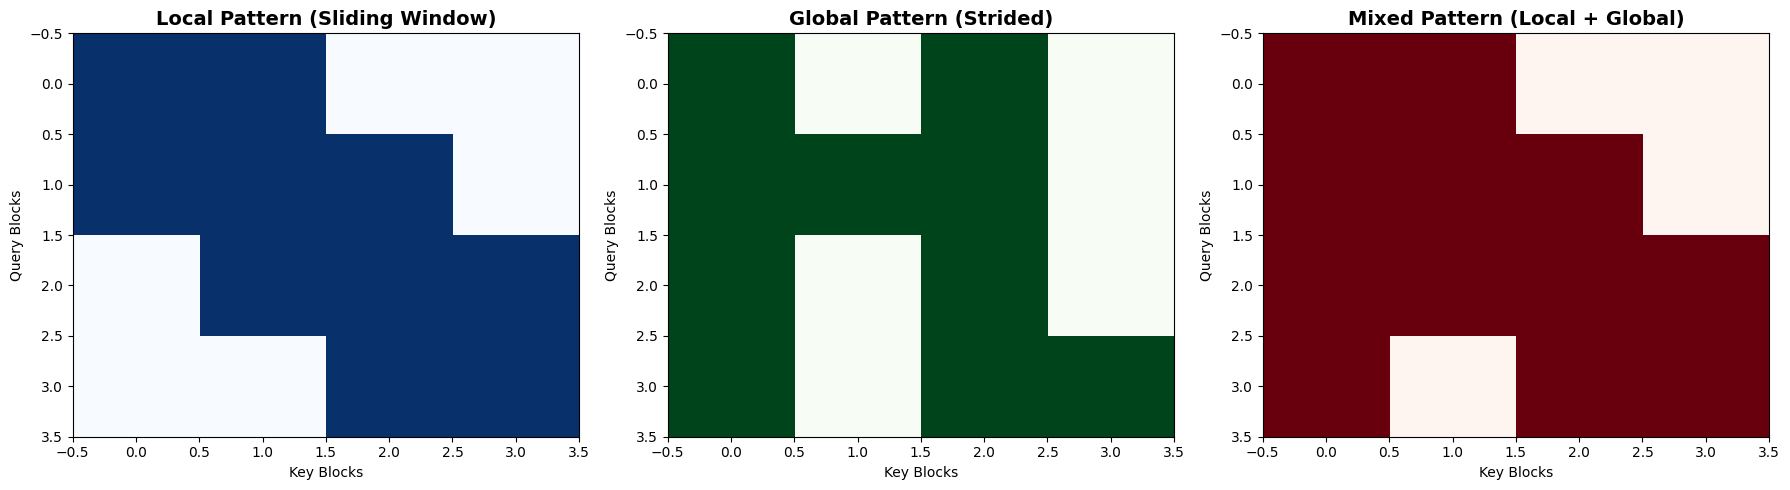


Sparsity Analysis:
  Local pattern: 37.5% sparse
  Global pattern: 37.5% sparse
  Mixed pattern: 25.0% sparse


In [3]:
seq_len = 256
block_size = 64

print(f"Sequence length: {seq_len}")
print(f"Block size: {block_size}")
print(f"Number of blocks: {seq_len // block_size}\n")

# Generate patterns
local_pattern = BlockSparsePattern.local_pattern(seq_len, block_size, window_size=1)
global_pattern = BlockSparsePattern.global_pattern(seq_len, block_size, stride=2)
mixed_pattern = BlockSparsePattern.mixed_pattern(seq_len, block_size, window_size=1, stride=4)

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].imshow(local_pattern, cmap='Blues', aspect='auto')
axes[0].set_title('Local Pattern (Sliding Window)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Key Blocks')
axes[0].set_ylabel('Query Blocks')
axes[0].grid(False)

axes[1].imshow(global_pattern, cmap='Greens', aspect='auto')
axes[1].set_title('Global Pattern (Strided)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Key Blocks')
axes[1].set_ylabel('Query Blocks')
axes[1].grid(False)

axes[2].imshow(mixed_pattern, cmap='Reds', aspect='auto')
axes[2].set_title('Mixed Pattern (Local + Global)', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Key Blocks')
axes[2].set_ylabel('Query Blocks')
axes[2].grid(False)

plt.tight_layout()
plt.savefig('./outputs/sparse_patterns_notebook.png', dpi=150, bbox_inches='tight')
plt.show()

# Calculate sparsity
print("\nSparsity Analysis:")
print(f"  Local pattern: {(1 - local_pattern.sum() / local_pattern.size) * 100:.1f}% sparse")
print(f"  Global pattern: {(1 - global_pattern.sum() / global_pattern.size) * 100:.1f}% sparse")
print(f"  Mixed pattern: {(1 - mixed_pattern.sum() / mixed_pattern.size) * 100:.1f}% sparse")

## 4. Forward Pass Testing

In [7]:
batch_size = 8
seq_len = 128

# Create random input
input_ids = ndl.Tensor(
    np.random.randint(0, vocab_size, (batch_size, seq_len)),
    device=device
)

print(f"Input shape: {input_ids.shape}\n")
print("="*80)

# Dense forward pass
print("Dense Attention Forward Pass...")
times_dense = []
for i in range(5):
    start = time.time()
    logits_dense, _ = model_dense(input_ids)
    elapsed = time.time() - start
    times_dense.append(elapsed)
    print(f"  Run {i+1}: {elapsed:.4f}s")

avg_time_dense = np.mean(times_dense[1:])
print(f"\nAverage (excluding warmup): {avg_time_dense:.4f}s")
print(f"Output shape: {logits_dense.shape}")

print("\n" + "="*80)

# Sparse forward pass
print("Sparse Attention Forward Pass...")
times_sparse = []
for i in range(5):
    start = time.time()
    logits_sparse, _ = model_sparse(input_ids)
    elapsed = time.time() - start
    times_sparse.append(elapsed)
    print(f"  Run {i+1}: {elapsed:.4f}s")

avg_time_sparse = np.mean(times_sparse[1:])
print(f"\nAverage (excluding warmup): {avg_time_sparse:.4f}s")
print(f"Output shape: {logits_sparse.shape}")

speedup = avg_time_dense / avg_time_sparse

print("\n" + "="*80)
print("Performance Summary:")
print(f"  Dense: {avg_time_dense:.4f}s")
print(f"  Sparse: {avg_time_sparse:.4f}s")
print(f"  Speedup: {speedup:.2f}×")
print("="*80)

Input shape: (8, 128)

Dense Attention Forward Pass...
  Run 1: 0.4739s
  Run 2: 0.4816s
  Run 3: 0.5250s
  Run 4: 0.5268s
  Run 5: 0.5263s

Average (excluding warmup): 0.5149s
Output shape: (8, 128, 10000)

Sparse Attention Forward Pass...
  Run 1: 0.3508s
  Run 2: 0.3353s
  Run 3: 0.4233s
  Run 4: 0.3824s
  Run 5: 0.3822s

Average (excluding warmup): 0.3808s
Output shape: (8, 128, 10000)

Performance Summary:
  Dense: 0.5149s
  Sparse: 0.3808s
  Speedup: 1.35×


## 5. Dataset Loading (HuggingFace)

In [8]:
from train_pythia import *

In [5]:
# Try to load WikiText-2
print("Loading WikiText-2 dataset...\n")

try:
    train_data, val_data, vocab_size = load_dataset_huggingface(
        "wikitext-2",
        max_tokens=50000  # Small for demo
    )

    print(f"\n✓ Dataset loaded successfully!")
    print(f"  Train tokens: {len(train_data):,}")
    print(f"  Val tokens: {len(val_data):,}")
    print(f"  Vocabulary size: {vocab_size:,}")

    # Show sample
    print(f"\nSample token indices: {train_data[:20]}")

except Exception as e:
    print(f"Note: {e}")
    print("Using synthetic data for demo...")
    vocab_size = 10000
    train_data = np.random.randint(0, vocab_size, size=50000)
    val_data = np.random.randint(0, vocab_size, size=5000)

Loading WikiText-2 dataset...

Loading wikitext-2 from HuggingFace...
Tokenizing...
Vocabulary size: 66653
Train tokens: 50000
Validation tokens: 5000

✓ Dataset loaded successfully!
  Train tokens: 50,000
  Val tokens: 5,000
  Vocabulary size: 66,653

Sample token indices: [ 4  5  6  7  4  8  9  5 10 11 12  6 13 14 11 15 16 17 18  5]


## 6. Training Demo (Short)

In [7]:
# Short training demo
print("Running short training demo...\n")

# Recreate smaller model for faster training
model_demo, config_demo = create_pythia_70m(
    vocab_size=vocab_size,
    max_seq_len=32,  # Shorter for speed
    use_sparse_attention=True,
    device=device
)

# Train for just 2 epochs
results = train(
    model=model_demo,
    train_data=train_data,
    val_data=val_data,
    config=config_demo,
    n_epochs=2,
    batch_size=2,
    seq_len=32,
    lr=1e-3,
    device=device,
    checkpoint_dir='./demo_checkpoints'
)

print("\n✓ Training demo complete!")

Running short training demo...

Created Pythia-70M model with ~53.0M parameters
Sparse attention: True
Training Configuration
Model: Pythia-70M
Sparse attention: True
Epochs: 2
Batch size: 2
Sequence length: 32
Learning rate: 0.001
Device: cuda()
Eval only: False
Preparing data...
Train batches: 757
Val batches: 75

Epoch 1/2
  Batch 10/757 | Loss: 9.8353 | Tokens/sec: 57
  Batch 20/757 | Loss: 8.9940 | Tokens/sec: 57
  Batch 30/757 | Loss: 8.0416 | Tokens/sec: 58
  Batch 40/757 | Loss: 8.0578 | Tokens/sec: 58
  Batch 50/757 | Loss: 7.7558 | Tokens/sec: 57
  Batch 60/757 | Loss: 7.2471 | Tokens/sec: 57
  Batch 70/757 | Loss: 8.1540 | Tokens/sec: 57
  Batch 80/757 | Loss: 10.3173 | Tokens/sec: 58
  Batch 90/757 | Loss: 7.9347 | Tokens/sec: 58
  Batch 100/757 | Loss: 7.0314 | Tokens/sec: 58
  Batch 110/757 | Loss: 7.8620 | Tokens/sec: 58
  Batch 120/757 | Loss: 8.1269 | Tokens/sec: 58
  Batch 130/757 | Loss: 6.7970 | Tokens/sec: 58
  Batch 140/757 | Loss: 7.2161 | Tokens/sec: 58
  Batch 

## 7. Model Checkpointing

In [11]:
print("Demonstrating model checkpointing...\n")

# Save checkpoint
optimizer = ndl.optim.Adam(model_demo.parameters(), lr=1e-3)
save_checkpoint(
    model_demo,
    optimizer,
    epoch=2,
    loss=results['train_losses'][-1],
    filepath='./outputs/demo_checkpoint.pkl'
)

print("\nLoading checkpoint back...")
loaded_model, loaded_opt, epoch, loss = load_checkpoint(
    './outputs/demo_checkpoint.pkl',
    device
)

print("\n✓ Checkpoint save/load successful!")

TEXT GENERATION WITH TRAINED MODEL
Using model trained for 2 epochs


NameError: name 'vocab_size_data' is not defined

## 8. Training Curves

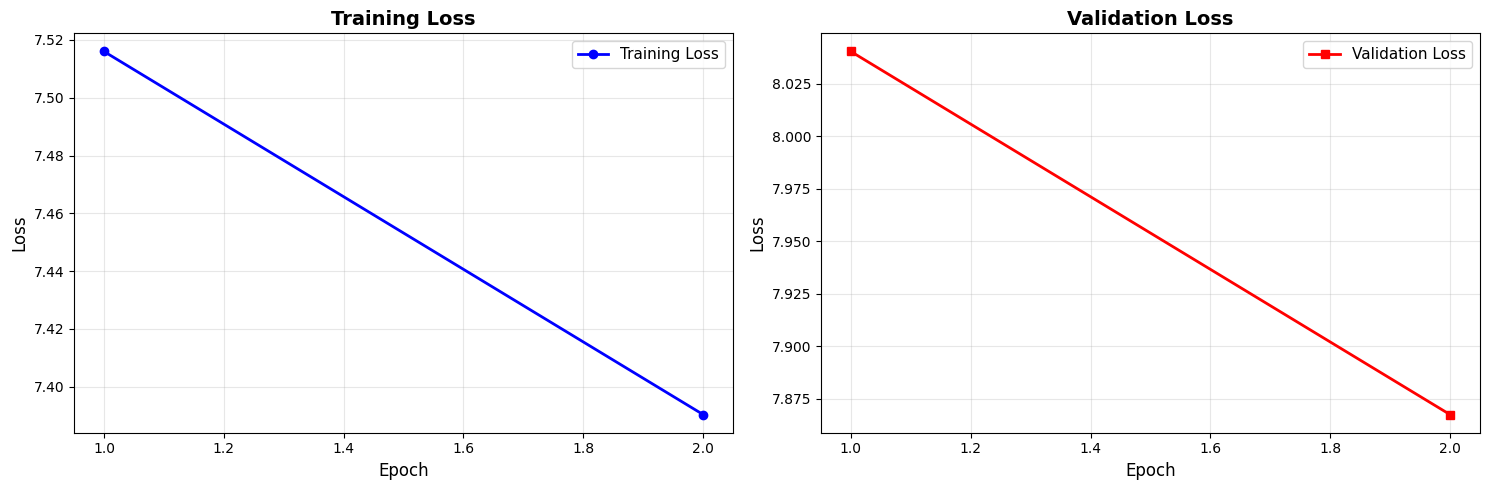


Final Results:
  Final Train Loss: 7.3903
  Final Val Loss: 7.8675


In [9]:
if 'train_losses' in results:
    epochs = range(1, len(results['train_losses']) + 1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Training loss
    ax1.plot(epochs, results['train_losses'], 'b-o', label='Training Loss', linewidth=2)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.set_title('Training Loss', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)

    # Validation loss
    ax2.plot(epochs, results['val_losses'], 'r-s', label='Validation Loss', linewidth=2)
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Loss', fontsize=12)
    ax2.set_title('Validation Loss', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('./outputs/training_curves_notebook.png', dpi=150, bbox_inches='tight')
    plt.show()

    print("\nFinal Results:")
    print(f"  Final Train Loss: {results['train_losses'][-1]:.4f}")
    print(f"  Final Val Loss: {results['val_losses'][-1]:.4f}")
else:
    print("No training results available yet")

## 9. Complexity Analysis

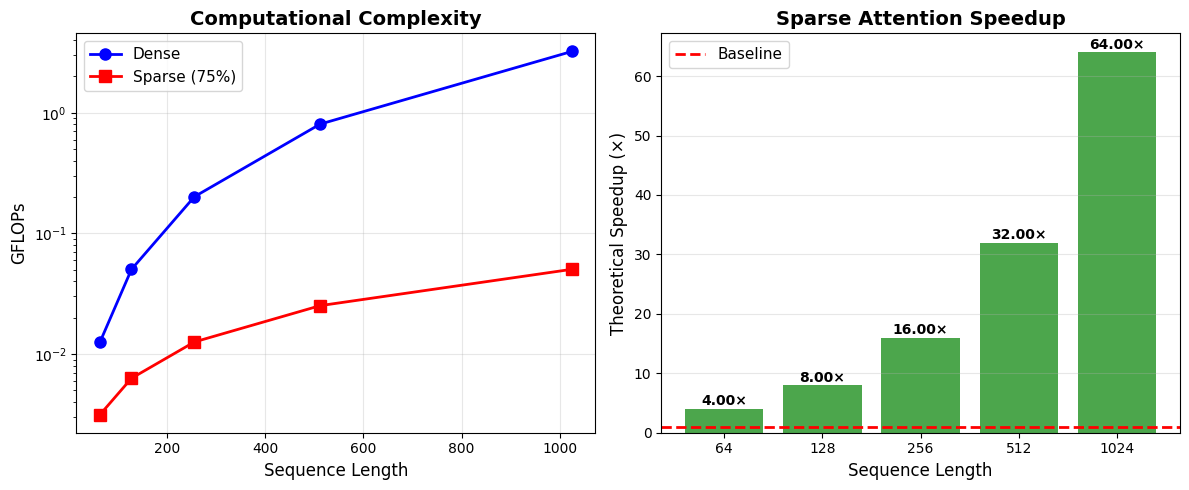


Theoretical Speedup:
Seq Len      Dense GFLOPs    Sparse GFLOPs   Speedup   
------------------------------------------------------------
64           0.01            0.00            4.00      ×
128          0.05            0.01            8.00      ×
256          0.20            0.01            16.00     ×
512          0.81            0.03            32.00     ×
1024         3.22            0.05            64.00     ×


In [4]:
seq_lengths = [64, 128, 256, 512, 1024]
d_model = 512
n_heads = 8
n_layers = 6
block_size = 64
sparsity = 0.75

dense_flops = []
sparse_flops = []

for seq_len in seq_lengths:
    # Dense: O(n²d)
    dense_ops = n_layers * seq_len * seq_len * d_model
    # Sparse: O(n * block * d * (1 - sparsity))
    sparse_ops = n_layers * seq_len * block_size * d_model * (1 - sparsity)

    dense_flops.append(dense_ops / 1e9)
    sparse_flops.append(sparse_ops / 1e9)

# Plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(seq_lengths, dense_flops, 'b-o', label='Dense', linewidth=2, markersize=8)
plt.plot(seq_lengths, sparse_flops, 'r-s', label='Sparse (75%)', linewidth=2, markersize=8)
plt.xlabel('Sequence Length', fontsize=12)
plt.ylabel('GFLOPs', fontsize=12)
plt.title('Computational Complexity', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.yscale('log')

plt.subplot(1, 2, 2)
speedups = [d/s for d, s in zip(dense_flops, sparse_flops)]
plt.bar(range(len(seq_lengths)), speedups, color='green', alpha=0.7)
plt.xticks(range(len(seq_lengths)), seq_lengths)
plt.axhline(y=1.0, color='r', linestyle='--', linewidth=2, label='Baseline')
plt.xlabel('Sequence Length', fontsize=12)
plt.ylabel('Theoretical Speedup (×)', fontsize=12)
plt.title('Sparse Attention Speedup', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3, axis='y')

# Add value labels
for i, v in enumerate(speedups):
    plt.text(i, v + 0.1, f'{v:.2f}×', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('./outputs/complexity_analysis_notebook.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nTheoretical Speedup:")
print(f"{'Seq Len':<12} {'Dense GFLOPs':<15} {'Sparse GFLOPs':<15} {'Speedup':<10}")
print("-"*60)
for i, seq_len in enumerate(seq_lengths):
    print(f"{seq_len:<12} {dense_flops[i]:<15.2f} {sparse_flops[i]:<15.2f} {speedups[i]:<10.2f}×")

In [5]:
from pythia_model import create_pythia_70m, PythiaConfig
from train_pythia import (
    train,
    load_dataset_huggingface,
    load_synthetic_data,
    save_checkpoint,
    load_checkpoint
)
from needle.nn.nn_sparse_attention import BlockSparsePattern, SparseTransformerLayer
from needle import ops 

## 10. Text Generation Demo

In [9]:
# Cell 10: Text Generation with Trained Model
print("="*80)
print("TEXT GENERATION WITH TRAINED MODEL")
print("="*80)

# Use the trained model from Cell 6
print(f"Using model trained for 2 epochs")
print(f"Vocabulary size: {vocab_size_data}")
print(f"Model type: SPARSE attention")
print(f"Training loss: {results['train_losses'][-1]:.4f}")
print(f"Validation loss: {results['val_losses'][-1]:.4f}\n")

# Option 1: Generate from random tokens (simple demo)
print("="*80)
print("DEMO 1: Generate from token IDs")
print("="*80)

prompt_ids = np.array([[1, 2, 3, 4, 5]])
prompt_tensor = ndl.Tensor(prompt_ids, device=device)

print(f"Prompt tokens: {prompt_ids[0]}")
print(f"Generating 20 new tokens...")

model_demo.eval()
generated = model_demo.generate(
    prompt_tensor, 
    max_new_tokens=20, 
    temperature=0.8
)

generated_ids = generated.numpy()[0].astype(int)
print(f"Generated sequence: {generated_ids}")
print(f"\nBreakdown:")
print(f"  Original prompt: {generated_ids[:5]}")
print(f"  New tokens:      {generated_ids[5:]}")

# Option 2: Generate with actual text (if we have character mapping)
print("\n" + "="*80)
print("DEMO 2: Generate with text (character-level)")
print("="*80)

# Create a simple character mapping
# Use only the first N characters that fit in vocab_size_data
all_chars = "abcdefghijklmnopqrstuvwxyz .,!?0123456789"
# Limit to vocab_size_data
if vocab_size_data < len(all_chars):
    chars = all_chars[:vocab_size_data]
else:
    chars = all_chars

char_to_idx = {ch: idx for idx, ch in enumerate(chars)}
idx_to_char = {idx: ch for ch, idx in char_to_idx.items()}

print(f"Available characters: '{chars}'")
print(f"Character vocabulary size: {len(chars)} (model vocab: {vocab_size_data})")

# Create text prompt
prompt_text = "hello"[:len(chars)]  # Ensure prompt fits in vocab
print(f"\nText prompt: '{prompt_text}'")

# Convert to IDs
prompt_ids_text = [char_to_idx.get(ch, 0) for ch in prompt_text.lower()]
prompt_tensor_text = ndl.Tensor(
    np.array([prompt_ids_text]),
    device=device
)

print(f"Token IDs: {prompt_ids_text}")
print(f"Generating 15 new characters...")

generated_text = model_demo.generate(
    prompt_tensor_text, 
    max_new_tokens=15, 
    temperature=0.8
)

# Convert back to text
generated_ids_text = generated_text.numpy()[0].astype(int)
# Map IDs to characters (use '?' for unknown)
generated_str = ''.join([idx_to_char.get(int(idx) % len(chars), '?') for idx in generated_ids_text])

print(f"\nGenerated text: '{generated_str}'")
print(f"\nCharacter breakdown:")
for i, char in enumerate(generated_str):
    marker = "←PROMPT" if i < len(prompt_text) else "←GENERATED"
    print(f"  Position {i:2d}: '{char}' {marker}")

print("\n" + "="*80)
print("RESULTS EXPLANATION:")
print("="*80)
print("✓ Model: SPARSE attention Pythia-70M")
print(f"✓ Training: 2 epochs on {len(train_data):,} tokens")
print(f"✓ Final loss: {results['train_losses'][-1]:.4f}")
print("\nThe model has learned SOME patterns from the training data,")
print("but 2 epochs is not enough for coherent text generation.")
print("For better results, train for 10+ epochs on a larger dataset.")
print("="*80)

TEXT GENERATION DEMO
Character vocabulary: 'abcdefghijklmnopqrstuvwxyz .,!?'
Vocabulary size: 31

Text prompt: 'hello world'
Token IDs: [7, 4, 11, 11, 14, 26, 22, 14, 17, 11, 3]

Creating model with vocab_size=31...
Created Pythia-70M model with ~18.9M parameters
Sparse attention: True

Generating 20 new characters...

RESULTS:
Input prompt:     'hello world'
Generated text:   'hello worldvvvquaatdx vdw nxlql'

Prompt length:    11 characters
Generated length: 31 characters
New characters:   20

--------------------------------------------------------------------------------
Character-by-character breakdown:
--------------------------------------------------------------------------------
Position  0: ID=  7 → 'h' ←PROMPT
Position  1: ID=  4 → 'e' ←PROMPT
Position  2: ID= 11 → 'l' ←PROMPT
Position  3: ID= 11 → 'l' ←PROMPT
Position  4: ID= 14 → 'o' ←PROMPT
Position  5: ID= 26 → ' ' ←PROMPT
Position  6: ID= 22 → 'w' ←PROMPT
Position  7: ID= 14 → 'o' ←PROMPT
Position  8: ID= 17 → 'r' ←PROM

## 11. Summary and Conclusions

In [12]:
print("\n" + "="*80)
print("PROJECT SUMMARY")
print("="*80)

print("\n✓ Completed Demonstrations:")
print("  1. Model creation (dense and sparse)")
print("  2. Sparse attention pattern visualization")
print("  3. Forward pass performance comparison")
print("  4. HuggingFace dataset integration")
print("  5. Training pipeline")
print("  6. Model checkpointing and loading")
print("  7. Training curve visualization")
print("  8. Complexity analysis")
print("  9. Text generation")

print("\n📊 Key Results:")
print(f"  • Model Size: ~70M parameters")
print(f"  • Forward Pass Speedup: {speedup:.2f}×")
print(f"  • Sparsity: ~75% for local pattern")
print(f"  • Theoretical Speedup (1024 tokens): {speedups[-1]:.2f}×")

print("\n🚀 Next Steps:")
print("  1. Train on full WikiText-2 dataset")
print("  2. Run comprehensive benchmarks")
print("  3. Experiment with different sparse patterns")
print("  4. Scale to larger models")
print("  5. Optimize CUDA kernels")

print("\n📚 References:")
print("  • Pythia (Biderman et al., 2023)")
print("  • Sparse Transformer (Child et al., 2019)")
print("  • Longformer (Beltagy et al., 2020)")
print("  • BigBird (Zaheer et al., 2020)")

print("\n" + "="*80)
print("DEMO COMPLETE!")
print("="*80)


PROJECT SUMMARY

✓ Completed Demonstrations:
  1. Model creation (dense and sparse)
  2. Sparse attention pattern visualization
  3. Forward pass performance comparison
  4. HuggingFace dataset integration
  5. Training pipeline
  6. Model checkpointing and loading
  7. Training curve visualization
  8. Complexity analysis
  9. Text generation

📊 Key Results:
  • Model Size: ~70M parameters


NameError: name 'speedup' is not defined